# Assignment 4

In [10]:
library(tidyverse)
library(gridExtra)
library(infer)
library(broom)
library(gsDesign)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Question of Interest
Part One:
> Do the company's advertisements generate a meaningful increase in purchase conversion rates when compared to those not exposed to the advertisements?

Part Two:
> In a simulated longitudinal study, how does the implementation of various p-value adjustment methods (such as Pocock and Bonferroni) affect the interpretation of A/B testing results over time, specifically in assessing the effectiveness of the company's advertisements on purchase conversion rates?

## Exploratory Data Analysis

This dataset is for a marketing company to analyze the impact of advertising campaigns. It captures the details of individuals exposed to either a specific advertisement or a public service announcement. The dataset provides insights into whether the campaign led to a conversion, the number of ads seen by the individual, and details about the most active day and hour.

In [11]:
# data placed in a GitHub repository
url = "https://raw.githubusercontent.com/ZiyueChloeZhang/A-B-Testing/main/data/marketing_AB.csv"

# read data
marketing_raw <- read.csv(url)

str(marketing_raw)

'data.frame':	588101 obs. of  7 variables:
 $ X            : int  0 1 2 3 4 5 6 7 8 9 ...
 $ user.id      : int  1069124 1119715 1144181 1435133 1015700 1137664 1116205 1496843 1448851 1446284 ...
 $ test.group   : chr  "ad" "ad" "ad" "ad" ...
 $ converted    : chr  "False" "False" "False" "False" ...
 $ total.ads    : int  130 93 21 355 276 734 264 17 21 142 ...
 $ most.ads.day : chr  "Monday" "Tuesday" "Tuesday" "Tuesday" ...
 $ most.ads.hour: int  20 22 18 10 14 10 13 18 19 14 ...


Filter out irrelavent columns. Keep `test.group` and `converted`. Convert `converted` and 
`test.group` from `chr` to `lgl` and `fct`.

In [12]:
marketing <- marketing_raw %>% 
    select(test.group, converted, most.ads.day) %>%
    mutate(
        converted = as.logical(converted),
        test.group = as.factor(test.group)
    )
str(marketing)
summary(marketing)

'data.frame':	588101 obs. of  3 variables:
 $ test.group  : Factor w/ 2 levels "ad","psa": 1 1 1 1 1 1 1 1 1 1 ...
 $ converted   : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ most.ads.day: chr  "Monday" "Tuesday" "Tuesday" "Tuesday" ...


 test.group   converted       most.ads.day      
 ad :564577   Mode :logical   Length:588101     
 psa: 23524   FALSE:573258    Class :character  
              TRUE :14843     Mode  :character  

In [13]:
# Conversion rates by group
conversion_rates_by_group <- marketing %>%
  group_by(test.group) %>%
  summarize(ConversionRate = mean(converted == "TRUE"))
conversion_rates_by_group

test.group,ConversionRate
<fct>,<dbl>
ad,0.02554656
psa,0.01785411


### Visualization

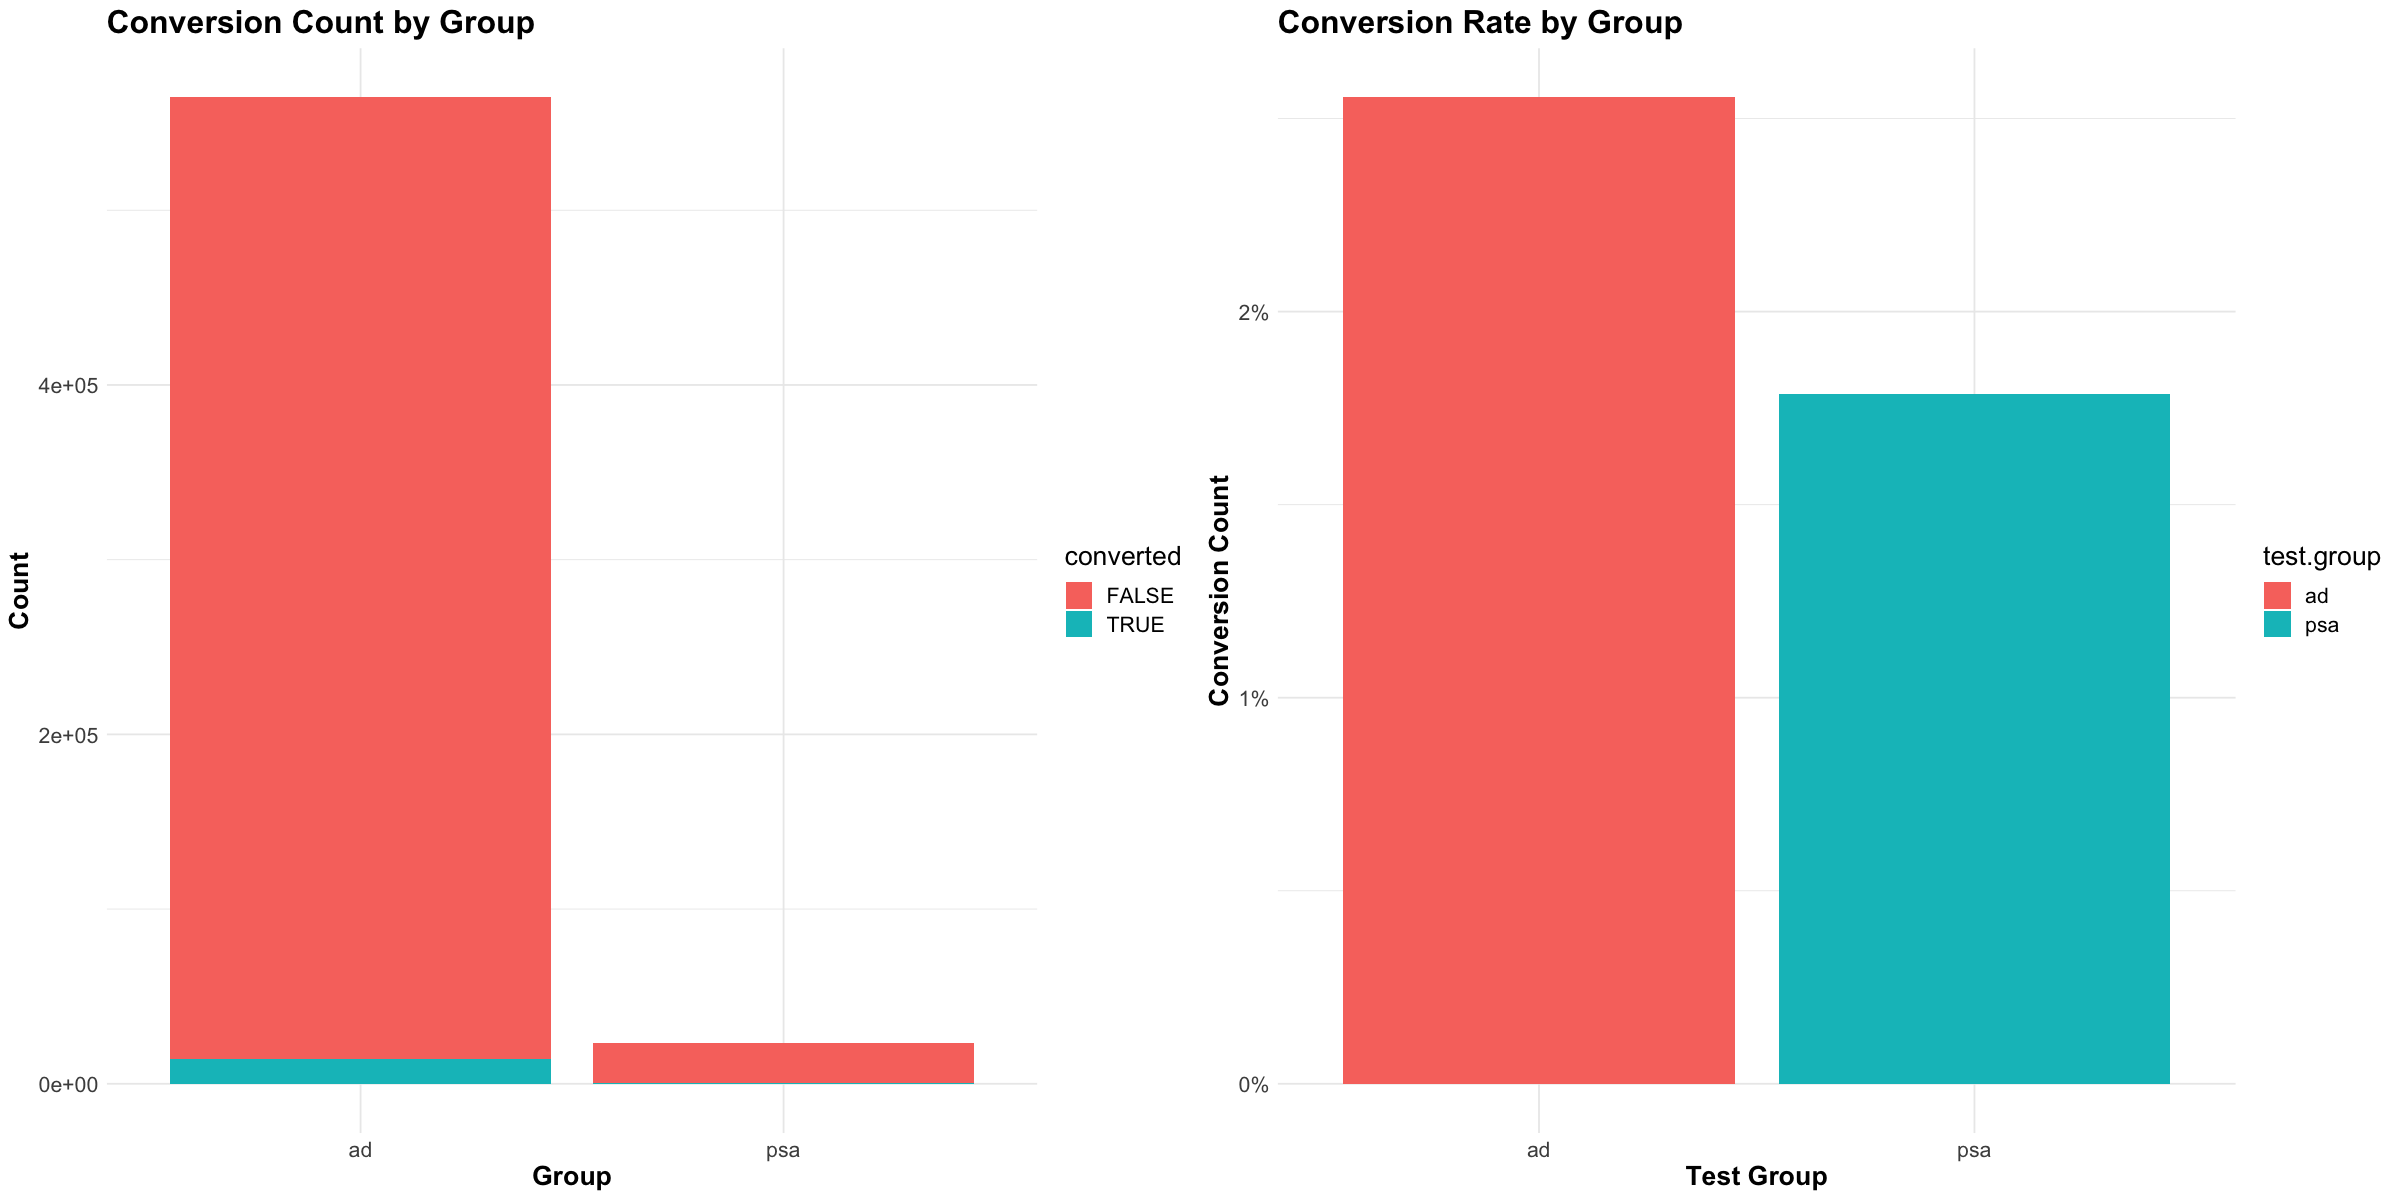

In [14]:
theme = theme_minimal() + theme(
    text = element_text(size = 16),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
)

conversion_count_by_group_bar <- ggplot(marketing, aes(x=test.group, fill=converted)) +
  geom_bar()+
  ggtitle("Conversion Count by Group") +
  xlab("Group") +
  ylab("Count") +
  theme

conversion_rates_by_group_bar = ggplot(conversion_rates_by_group, aes(x=test.group, y=ConversionRate, fill=test.group)) +
  geom_bar(stat="identity") +
  ggtitle("Conversion Rate by Group") +
  xlab("Test Group") +
  ylab("Conversion Count")+
  scale_y_continuous(labels = scales::percent) +
  theme

options(repr.plot.width=20, repr.plot.height=10)

grid.arrange(
    conversion_count_by_group_bar,
    conversion_rates_by_group_bar, 
    nrow = 1,
    widths = c(1, 1)
)

**Conversion Count by Group**: This bar chart shows the raw count of conversions for each group—those who have seen the advertisements ('ad') and those who have not been exposed to them ('psa'). The counts are further subdivided into 'TRUE' (converted) and 'FALSE' (not converted), indicated by different colors. This chart helps understand the absolute number of conversions and non-conversions in each group.

**Conversion Rate by Group**: This plot directly addresses the core question by comparing the average conversion rates between the groups exposed to advertisements ('ad') and the public service announcements ('psa'). A clear visual comparison can be made through the heights of the bars. The 'ad' group's bar is significantly higher, suggesting that advertisements may indeed be effective at increasing conversions.

## Assignment 3: Methods and Plan

### Part One: Simple Inference Analysis
**Question**:
> Do the company's advertisements generate a meaningful increase in purchase conversion rates when compared to those not exposed to the advertisements?


**Null Hypothesis**: There is no difference in purchase conversion rates between the group exposed to the company's advertisements and the group not exposed to the advertisements.

$$H_0: \mu_{ad} = \mu_{psa}$$

#### Method: Welch's T-test

The Welch's T-test is selected to compare the means of two independent groups. Given the binary nature of our dataset (`ad` vs. `psa` and converted vs. not converted), this test is ideal for determining whether there is a statistically significant difference in conversion rates between the two groups. Since whether the variance of the population is unknown, Welch's T-test is chosen over the two-sample T-test. 

Assumptions:
- Each observation is independent of the others.

Limitations:
- Since the outcomes are just converted vs. not converted, using the 'mean' mainly shows the proportion of 'True' cases. However, this doesn't fully describe the nature of binary data.

#### Method: Permuatation Test
The permutation test is suitable for data that may not meet the normality assumption required for a two-sample T-test. It is effective for analyzing binary outcomes (like 'converted' vs. 'not converted').

Assumptions:
- The observations are exchangeable, meaning the assignment of data points to either the 'ad' or 'psa' group should not affect the overall distribution of the data.
- Each observation is independent of the others.

Limitations:
- It is computationally intensive because it involves calculating the test statistic for many permutations.
- Permutation tests do not have confidence intervals as two-sample T-test does.

### Part Two: Simulation Study

**Question**:
> In a simulated longitudinal study, how does the implementation of various p-value adjustment methods (such as Pocock and Bonferroni) affect the interpretation of A/B testing results over time, specifically in assessing the effectiveness of the company's advertisements on purchase conversion rates?

**Motivation**:
This simulation is crucial for understanding the dynamics of A/B testing in a setting that mimics real-world scenarios. It is aiming to discover the pitfalls of continuous data monitoring, such as the issue of 'principle peeking' and how it might lead to premature conclusions. The study also aims to identify the most appropriate statistical methods for longitudinal data analysis in marketing research.

**Simulation**:
The simulated time period for data collection will be determined (e.g., over 28 days/4 weeks). The dataset will be divided accordingly, with each segment representing a 'day' of data collection. This simulation will simulate a real-world scenario where data is collected and analyzed over time.

**Method**: At each time increment, a Welch's T-test will be conducted to compare the conversion rates between the `ad` and `psa` groups. This incremental approach allows for the analysis of data as it accumulates, similar to a real-time study. The study will explore the effects of Pocock, Bonferroni, O'Brien-Fleming adjustments on the interpretation of the results.

Assumption:
- Each week's data is independent of previous weeks.

Limitation:
- Initial weeks with smaller data sets might show more variability.


## Assignment 4: Implementation of a proposed model

### Part One: Simple Inference Analysis using Welch's T test

Alternative Hypothesis:

$$ H_a = \mu_{\text{ad}} > \mu_{\text{psa}} $$

The mean conversion rate ($\mu $) for the group exposed to advertisements (ad) is greater than the mean conversion rate for the group not exposed to advertisements (psa).

In [15]:
# Performing Welch's T-test
test_result <- t.test(
    x = marketing %>% filter(test.group == "ad") %>% pull(converted),
    y = marketing %>% filter(test.group == "psa") %>% pull(converted),
    # testing whether the mean of x is greater than the mean of the y
    alternative = "greater", 
    # the Welch's T-test does not assume equal variances in the two groups
    var.equal = FALSE
)

tidy(test_result)

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.007692453,0.02554656,0.01785411,8.657162,2.553804e-18,26384.19,0.006230842,Inf,Welch Two Sample t-test,greater


The Welch's T-test results indicate a significant difference in conversion rates between the ad group (mean = 0.0255) and the psa group (mean = 0.0179), with a t-statistic of 8.66. The positive estimate of 0.0077 suggests that the conversion rate for the ad group is higher than that of the psa group. Since the p-value is approximately 2.55e-18, which is way less than the significance level 0.05, we are confident enough to reject $H_0$. Therefore, we have statistical evidence to state that the company's advertisements generate a meaningful increase in purchase conversion rates when compared to those exposed to the public annoucement service.

### Part Two: Simulated Sequential A/B Testing

**Data simulation**

Add the following columns: `day_num`, `week_num` and `simulated_date`
- `day_num`: Represents a numerical mapping of the weekdays (e.g., Monday as 1, Tuesday as 2) based on the day when the most ads were seen.
- `week_num`: A randomly assigned week number (ranging from 0 to 3) for each entry, simulating the allocation of data across four weeks.
- `simulated_date`: Combining day_num and week_num, to simulate a specific day in the 4-week data collection timeframe.


In [16]:
day_mapping <- c("Monday" = 1, "Tuesday" = 2, "Wednesday" = 3, "Thursday" = 4, 
                 "Friday" = 5, "Saturday" = 6, "Sunday" = 7)

set.seed(1234)
marketing_simulated = marketing %>%
    mutate(
        # Map 'most.ads.day' to a number
        day_num = day_mapping[most.ads.day],
        # Randomly assign each entry to one of the 4 weeks
        week_num = sample(0:3, nrow(marketing), replace = TRUE),
        # Create the simulated date (day within the 28-day period)
        simulated_date = day_num + week_num * 7)

head(marketing_simulated)


,test.group,converted,most.ads.day,day_num,week_num,simulated_date
,<fct>,<lgl>,<chr>,<dbl>,<int>,<dbl>
1,ad,FALSE,Monday,1,3,22
2,ad,FALSE,Tuesday,2,3,23
3,ad,FALSE,Tuesday,2,1,9
4,ad,FALSE,Tuesday,2,1,9
5,ad,FALSE,Friday,5,0,5
6,ad,FALSE,Saturday,6,3,27


Extracting data from the first two weeks:

In [17]:
marketing_simulated_2_weeks <- marketing_simulated %>% 
    filter(week_num < 2)
head(marketing_simulated_2_weeks)

,test.group,converted,most.ads.day,day_num,week_num,simulated_date
,<fct>,<lgl>,<chr>,<dbl>,<int>,<dbl>
1,ad,FALSE,Tuesday,2,1,9
2,ad,FALSE,Tuesday,2,1,9
3,ad,FALSE,Friday,5,0,5
4,ad,FALSE,Sunday,7,0,7
5,ad,FALSE,Tuesday,2,0,2
6,ad,FALSE,Monday,1,1,8


`incremental_daily_t_test`, is a function to perform daily Welch's T-tests. It iterates over each unique day in the dataset (sorted in ascending order), extracting the samples for both groups up to and including each day.

In [18]:
# reference: Tutorial 2
incremental_daily_t_test <- function(data, alpha) {
  results_df <- tibble(
    day = integer(),
    statistic = numeric(),
    p_value = numeric(),
    sample_size = integer(),
  )
  
  unique_days <- sort(unique(data$simulated_date))
  
  for (day in unique_days) {
    ad_sample <- filter(data, test.group == "ad", simulated_date <= day)$converted
    psa_sample <- filter(data, test.group == "psa", simulated_date <= day)$converted
    
    # Check if both groups have data for the day
    if (length(ad_sample) > 0 && length(psa_sample) > 0) {
      # Perform Welch's T-test
      t_test_results <- t.test(
          as.numeric(ad_sample), 
          as.numeric(psa_sample),
          alternative = "greater",
          var.equal = FALSE,
      )
    
    results_df <- rbind(results_df, tibble(
        day = day,
        statistic = round(t_test_results$statistic, 4),
        p_value = round(t_test_results$p.value, 4),
        sample_size = length(ad_sample) + length(psa_sample)))
    }
  }
    
  return (results_df)
}


Perform `incremental_daily_t_test` for the first two weeks:

In [19]:
alpha = 0.05
results <- incremental_daily_t_test(marketing_simulated_2_weeks, alpha)
head(results)

day,statistic,p_value,sample_size
<dbl>,<dbl>,<dbl>,<int>
1,2.3647,0.0091,21683
2,4.5352,0.0000,41099
3,3.8111,0.0001,61425
4,3.5069,0.0002,82206
5,3.2081,0.0007,105437
6,3.3208,0.0005,126000


### Visualization of Critical Values in Sequential Testing:
This analysis involves four scenarios for determining critical values:

1. Unadjusted Critical Value (`unadjusted_crit`): The standard critical value for a given alpha level without any correction for multiple testing. It's calculated using the qnorm function, which finds the critical value from the standard normal distribution.

2. Bonferroni Critical Value (`bonferroni_crit`): Adjusts the critical value to account for multiple testing by dividing the alpha level by the number of tests (days). It's more conservative and increases the threshold for statistical significance.

3. Pocock Critical Value (`pocock_crit`): Obtained from the gsDesign function, which uses the Pocock method for sequential testing. This approach adjusts the critical value dynamically across multiple interim analyses.

4. O'Brien-Fleming Critical Value (`OF_crit`): Also derived using gsDesign, but with the O'Brien-Fleming method. This method is stringent in the early stages of testing and becomes less strict as the study progresses.

`sequential_crit_value_plot_with_correction` is to visualize these critical values:

sequential_crit_value_plot_with_correction: This plot displays the daily critical values obtained from the Welch's T-tests. Each day is plotted on the x-axis against its critical value on the y-axis. There are four lines and points for each of the four correction methods (Unadjusted, Bonferroni, Pocock, and O'Brien-Fleming). It visually compares the observed critical values against the threshold values for each correction method over time.

In [20]:
unadjusted_crit<- qnorm(1 - alpha)
unadjusted_crit

[1] 1.644854

In [21]:
number_of_tests <- length(unique(marketing_simulated$simulated_date))
bonferroni_crit<- qnorm(1 - alpha/number_of_tests)
bonferroni_crit

[1] 2.913726

In [22]:
design_pocock <- gsDesign(k = 14, #number of interim analysis planned
                          test.type = 1, # for one-sided tests
                          delta = 0, # default effect size
                          alpha = alpha, #type I error rate
                          beta = 0.2, # type II error rate
                          sfu = 'Pocock')
                          
pocock_crit<- design_pocock$upper$bound
pocock_crit

[1] 2.332252 2.332252 2.332252 2.332252 2.332252 2.332252 2.332252 2.332252
 [9] 2.332252 2.332252 2.332252 2.332252 2.332252 2.332252

In [23]:
design_of <- gsDesign(k = 14, #number of interim analysis planned
                          test.type = 1, # for one-sided tests
                          delta = 0, # default effect size
                          alpha = alpha, #type I error rate
                          beta = 0.2, # type II error rate
                          sfu = 'OF')
                          
OF_crit<- design_of$upper$bound
OF_crit

[1] 6.818710 4.821556 3.936784 3.409355 3.049420 2.783727 2.577230 2.410778
 [9] 2.272903 2.156265 2.055918 1.968392 1.891170 1.822377

Find the ealiest stopping day for each correction method. 

In [24]:
results_with_early_stopping_flag <- results %>%
  mutate(
      unadjust_stopping_flag = statistic > unadjusted_crit,
      bonferroni_stopping_flag = statistic > bonferroni_crit,
      pocock_stopping_flag = statistic > pocock_crit,
      OF_stopping_flag = statistic > OF_crit,
  )

first_unadjust_stopping_day <- results_with_early_stopping_flag %>%
  filter(unadjust_stopping_flag) %>%
  arrange(day) %>%
  slice(1) %>%
  .$day

first_bonferroni_stopping_day <- results_with_early_stopping_flag %>%
  filter(bonferroni_stopping_flag) %>%
  arrange(day) %>%
  slice(1) %>%
  .$day

first_pocock_stopping_day <- results_with_early_stopping_flag %>%
  filter(pocock_stopping_flag) %>%
  arrange(day) %>%
  slice(1) %>%
  .$day

first_OF_stopping_day <- results_with_early_stopping_flag %>%
  filter(OF_stopping_flag) %>%
  arrange(day) %>%
  slice(1) %>%
  .$day

stopping_days_df <- tibble(
  Method = c("Unadjusted", "Bonferroni", "Pocock", "O'Brien-Fleming"),
  First_Stopping_Day = c(first_unadjust_stopping_day, 
                         first_bonferroni_stopping_day, 
                         first_pocock_stopping_day, 
                         first_OF_stopping_day)
)
stopping_days_df



Method,First_Stopping_Day
<chr>,<dbl>
Unadjusted,1
Bonferroni,2
Pocock,1
O'Brien-Fleming,4


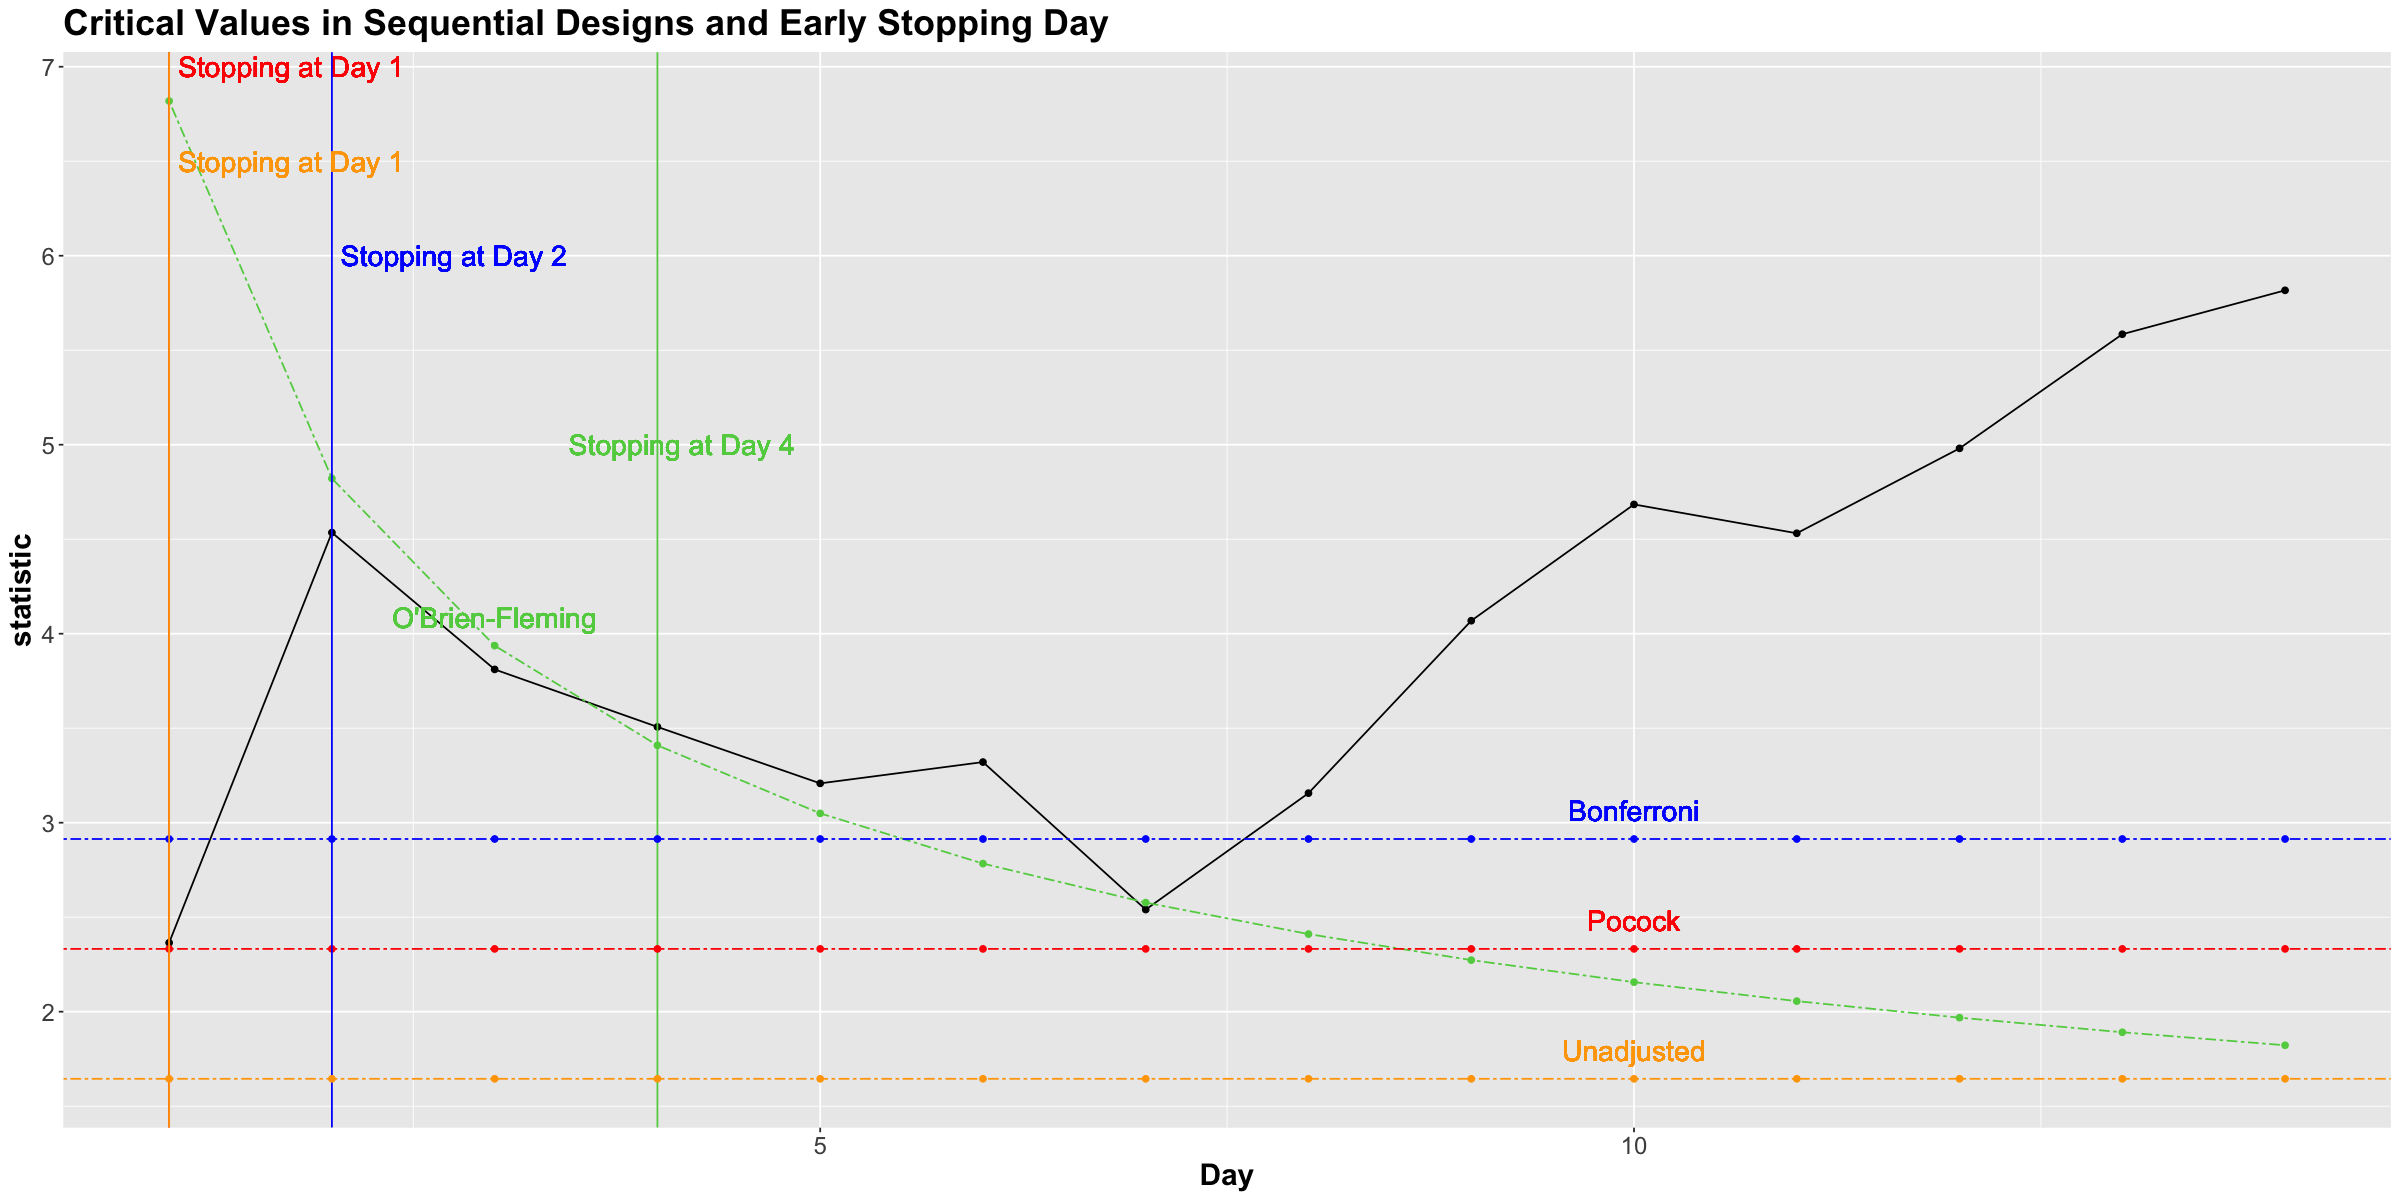

In [25]:
# reference: Tutorial 2 
sequential_crit_value_plot <- 
  results %>%
  ggplot() +
  geom_line(aes(x = day, y = statistic)) +
  theme(
    text = element_text(size = 18),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) + 
  geom_point(aes(x = day, y = statistic)) +
  ylab("statistic") +
  xlab("Day")


sequential_crit_value_plot_with_correction <- 
  sequential_crit_value_plot + 
  ggtitle("Critical Values in Sequential Designs and Early Stopping Day")+

  geom_line(aes(x = day, y = OF_crit),colour = 3, linetype = "twodash") +
  geom_point(aes(x = day, y = OF_crit), colour = 3) +
  geom_text(x=3, y= OF_crit[3] + 0.15, size=6, label="O'Brien-Fleming",colour = 3)+
  geom_vline(xintercept = first_OF_stopping_day, colour = 3) +
  geom_text(x=first_OF_stopping_day + 0.15, y=5, size=6, label="Stopping at Day 4",colour = 3)+

  geom_hline(yintercept = pocock_crit, colour = "red", linetype = "twodash") +
  geom_point(aes(x = day, y = pocock_crit), colour = "red") +
  geom_text(x=10, y=pocock_crit + 0.15, size=6, label="Pocock",colour = "red")+
  geom_vline(xintercept = first_pocock_stopping_day, colour = "red") +
  geom_text(x=first_pocock_stopping_day+ 0.75, y=7, size=6, label="Stopping at Day 1",colour = "red")+

  geom_hline(yintercept = bonferroni_crit, colour = "blue", linetype = "twodash") +
  geom_point(aes(x = day, y = rep(bonferroni_crit, 14)), colour = "blue") +
  geom_text(x=10, y=bonferroni_crit + 0.15, size=6, label="Bonferroni",colour = "blue")+
  geom_vline(xintercept = first_bonferroni_stopping_day, colour = "blue") +
  geom_text(x=first_bonferroni_stopping_day+ 0.75, y=6, size=6, label="Stopping at Day 2",colour = "blue")+

  geom_hline(yintercept = unadjusted_crit, colour = "orange", linetype = "twodash") +
  geom_point(aes(x = day, y = rep(unadjusted_crit, 14)), colour = "orange") +
  geom_text(x=10, y=unadjusted_crit + 0.15, size=6, label="Unadjusted", colour = "orange")+
  geom_vline(xintercept = first_unadjust_stopping_day, colour = "orange")+
  geom_text(x=first_unadjust_stopping_day+ 0.75, y=6.5, size=6, label="Stopping at Day 1",colour = "orange")

sequential_crit_value_plot_with_correction

**Result Interpretation**

The plot shows how different p-value adjustment methods influence the point at which an A/B testing study may be stopped early due to perceived effectiveness of an advertisement. 

The Unadjusted method suggests stopping at the very first day, indicating that without any correction for multiple testing, one might prematurely conclude effectiveness. 

The Bonferroni adjustment, being more conservative, suggests a first stopping day at Day 2, showing its stricter control over type I error by requiring a stronger signal of effectiveness to justify early stopping. 

The Pocock adjustment leads to stopping as early as the Unadjusted method, which may indicate that it is less conservative in this context, whereas the O'Brien-Fleming method, with the most conservative approach, suggests stopping at Day 4, indicating that it requires the strongest evidence over time to support the effectiveness of the company's advertisements.